In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from utils import create_lag_features, evaluate_model, plot_forecast_comparison, plot_residuals

## Data Preprocessing

In [58]:
# Plot styling
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 5)

In [59]:
# Load the dataset
file_path = "data/load_data.csv"
df = pd.read_csv(file_path, parse_dates=["timestamp"])

# Basic overview
print("Data shape:", df.shape)
print("\nData types:\n", df.dtypes)
df.head()


Data shape: (8760, 2)

Data types:
 timestamp    datetime64[ns]
load_kW             float64
dtype: object


,timestamp,load_kW
0,2023-01-01 00:00:00,37.483571
1,2023-01-01 01:00:00,30.426393
2,2023-01-01 02:00:00,30.738443
3,2023-01-01 03:00:00,32.008548
4,2023-01-01 04:00:00,20.838852


count    8668.000000
mean       35.272628
std        12.529991
min         0.000000
25%        25.220151
50%        35.274119
75%        45.022353
max       159.668384
Name: load_kW, dtype: float64

Missing values:
 timestamp     0
load_kW      92
dtype: int64


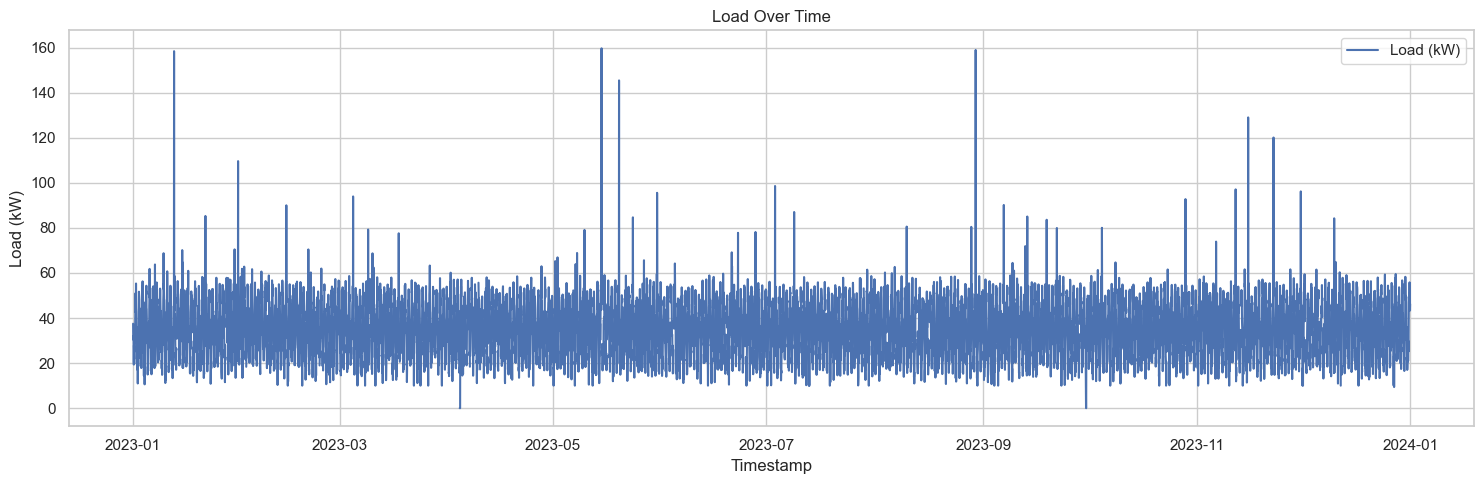

In [60]:
# Basic EDA on load_kW
print(df["load_kW"].describe())

# Check for missing values
print("\nMissing values:\n", df.isnull().sum())

# Plot load over time
plt.figure(figsize=(15, 5))
plt.plot(df["timestamp"], df["load_kW"], label="Load (kW)")
plt.title("Load Over Time")
plt.xlabel("Timestamp")
plt.ylabel("Load (kW)")
plt.legend()
plt.tight_layout()
plt.show()


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


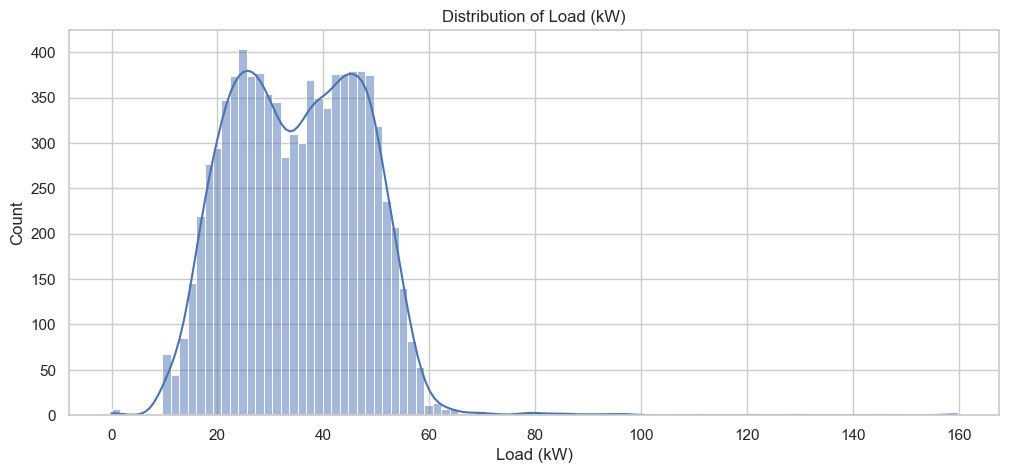

In [61]:
# Histogram of load_kW to check distribution
sns.histplot(df["load_kW"], bins=100, kde=True)
plt.title("Distribution of Load (kW)")
plt.xlabel("Load (kW)")
plt.show()


In [62]:
# Handle missing values
# Strategy: Linear interpolation for NaNs
print("Before interpolation:", df["load_kW"].isna().sum())
df["load_kW"] = df["load_kW"].interpolate(method="linear")
print("After interpolation:", df["load_kW"].isna().sum())


Before interpolation: 92
After interpolation: 0


In [63]:
# Handle zero-load outage periods
# Treat 0 values as outages and set them to NaN, then interpolate
zero_outages = (df["load_kW"] == 0).sum()
print("Zero-load outage count:", zero_outages)

df.loc[df["load_kW"] == 0, "load_kW"] = np.nan
df["load_kW"] = df["load_kW"].interpolate(method="linear")


Zero-load outage count: 7


In [64]:
# Detect and handle outliers using IQR method
Q1 = df["load_kW"].quantile(0.25)
Q3 = df["load_kW"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df["load_kW"] < lower_bound) | (df["load_kW"] > upper_bound)]
print("Outlier count:", outliers.shape[0])

# Replace outliers with NaN and interpolate
df.loc[(df["load_kW"] < lower_bound) | (df["load_kW"] > upper_bound), "load_kW"] = np.nan
df["load_kW"] = df["load_kW"].interpolate(method="linear")


Outlier count: 30


In [65]:
# Optional: Time-based feature engineering
df["hour"] = df["timestamp"].dt.hour
df["dayofweek"] = df["timestamp"].dt.dayofweek
df["is_weekend"] = df["dayofweek"].isin([5, 6]).astype(int)

# Show updated dataframe
df.head()


,timestamp,load_kW,hour,dayofweek,is_weekend
0,2023-01-01 00:00:00,37.483571,0,6,1
1,2023-01-01 01:00:00,30.426393,1,6,1
2,2023-01-01 02:00:00,30.738443,2,6,1
3,2023-01-01 03:00:00,32.008548,3,6,1
4,2023-01-01 04:00:00,20.838852,4,6,1


In [66]:
# Final check: Any remaining NaNs?
print("Final missing value count:", df.isna().sum().sum())

# Optional: Save cleaned data for modeling later
df.to_csv("data/cleaned_load_data.csv", index=False)


Final missing value count: 0


## Baseline Forecasting (24-Hour Horizon)


In [67]:
# Baseline Forecasting using previous day's values

# Load cleaned and preprocessed data
df = pd.read_csv("data/cleaned_load_data.csv", parse_dates=["timestamp"])
df = df.sort_values("timestamp").reset_index(drop=True)


# Ensure data is sorted by timestamp
df = df.sort_values("timestamp").reset_index(drop=True)

# Determine the last available timestamp in the dataset
last_timestamp = df["timestamp"].max()
print("Last timestamp in dataset:", last_timestamp)

# Define forecast horizon: next 24 hours
forecast_start = last_timestamp + pd.Timedelta(hours=1)
forecast_end = last_timestamp + pd.Timedelta(hours=24)
forecast_index = pd.date_range(start=forecast_start, end=forecast_end, freq='h')

print("Forecast range:", forecast_index[0], "to", forecast_index[-1])



Last timestamp in dataset: 2023-12-31 23:00:00
Forecast range: 2024-01-01 00:00:00 to 2024-01-01 23:00:00


In [ ]:
# Baseline strategy: Use load values from the same hours 24 hours earlier
# Find values exactly 24 hours before the forecast range
baseline_reference_time = forecast_index - pd.Timedelta(days=1)
baseline_forecast = df.set_index("timestamp").loc[baseline_reference_time]["load_kW"].values

# Construct forecast DataFrame
baseline_df = pd.DataFrame({
    "timestamp": forecast_index,
    "predicted_load_kW": baseline_forecast
})
baseline_df.head()


,timestamp,predicted_load_kW
0,2024-01-01 00:00:00,36.035697
1,2024-01-01 01:00:00,29.921349
2,2024-01-01 02:00:00,34.890606
3,2024-01-01 03:00:00,16.981414
4,2024-01-01 04:00:00,18.252892


In [69]:
# Define the evaluation range: last 24 hours of known data
eval_end = df["timestamp"].max()
eval_start = eval_end - pd.Timedelta(hours=23)  # inclusive range

# Actual values
actual_slice = df.set_index("timestamp").loc[eval_start:eval_end]["load_kW"].values

# Baseline forecast: use values from 24 hours before that
ref_start = eval_start - pd.Timedelta(hours=24)
ref_end = eval_end - pd.Timedelta(hours=24)
baseline_slice = df.set_index("timestamp").loc[ref_start:ref_end]["load_kW"].values

# Construct comparison DataFrame
timestamps = df.set_index("timestamp").loc[eval_start:eval_end].index
baseline_df = pd.DataFrame({
    "timestamp": timestamps,
    "actual_load_kW": actual_slice,
    "predicted_load_kW": baseline_slice
})


In [70]:
# Compute error metrics

y_true = baseline_df["actual_load_kW"]
y_pred = baseline_df["predicted_load_kW"]

mae, rmse, mape = evaluate_model(y_true, y_pred)

print(f"Baseline Forecast Error Metrics:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")


Baseline Forecast Error Metrics:
MAE: 5.46
RMSE: 6.72
MAPE: 17.69%


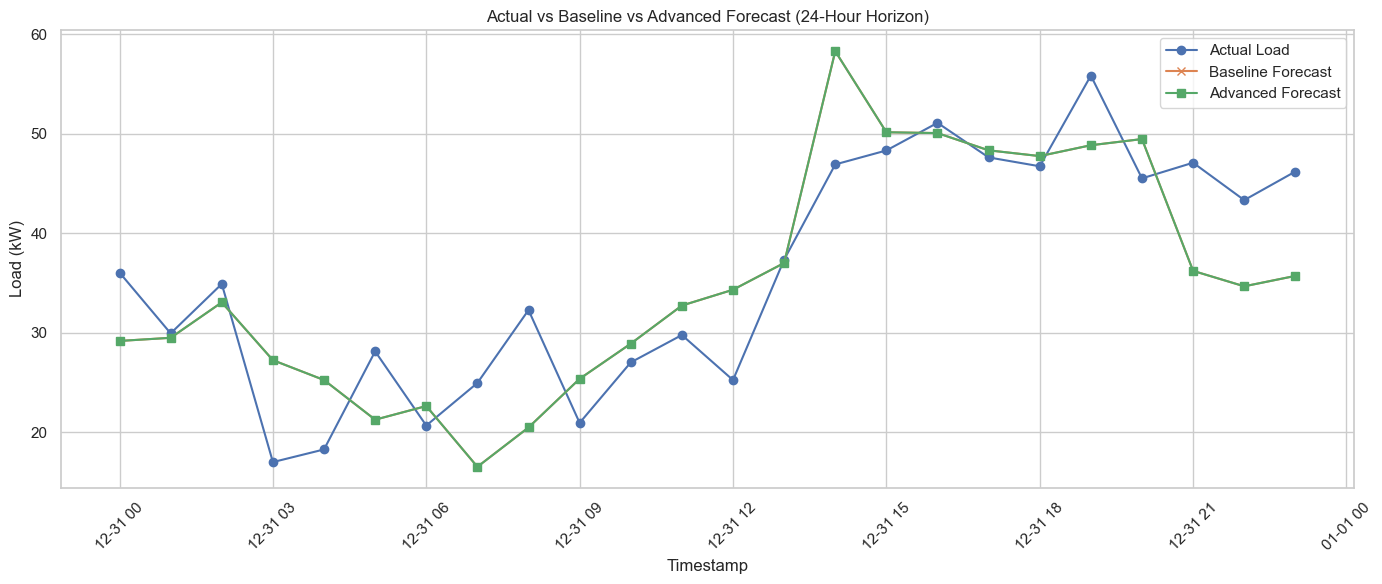

In [71]:
# Plot actual vs baseline predicted load
plot_forecast_comparison(
    timestamps=baseline_df["timestamp"],
    actual=baseline_df["actual_load_kW"],
    baseline=baseline_df["predicted_load_kW"],
    advanced=baseline_df["predicted_load_kW"]
)


## Advanced Forecasting using Random Forest


In [72]:
# Generate lag features (previous 1–3 hour values)
df_lagged = create_lag_features(df, lags=[1, 2, 3])
df_model = df_lagged.dropna().copy()


In [73]:
# Define features and target
features = ["hour", "dayofweek", "is_weekend", "load_kW_t-1", "load_kW_t-2", "load_kW_t-3"]
target = "load_kW"


In [74]:
# Split into train/test using the last 24 hours as test
train_df = df_model.iloc[:-24]
test_df = df_model.iloc[-24:]

X_train = train_df[features]
y_train = train_df[target]

X_test = test_df[features]
y_test = test_df[target]


In [75]:
# Train the Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict for the next 24 hours
y_pred_rf = model.predict(X_test)


In [76]:
# Evaluate model
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)
mape_rf = mean_absolute_percentage_error(y_test, y_pred_rf) * 100

print("Random Forest Forecast Error Metrics:")
print(f"MAE: {mae_rf:.2f}")
print(f"RMSE: {rmse_rf:.2f}")
print(f"MAPE: {mape_rf:.2f}%")


Random Forest Forecast Error Metrics:
MAE: 3.88
RMSE: 4.99
MAPE: 12.41%


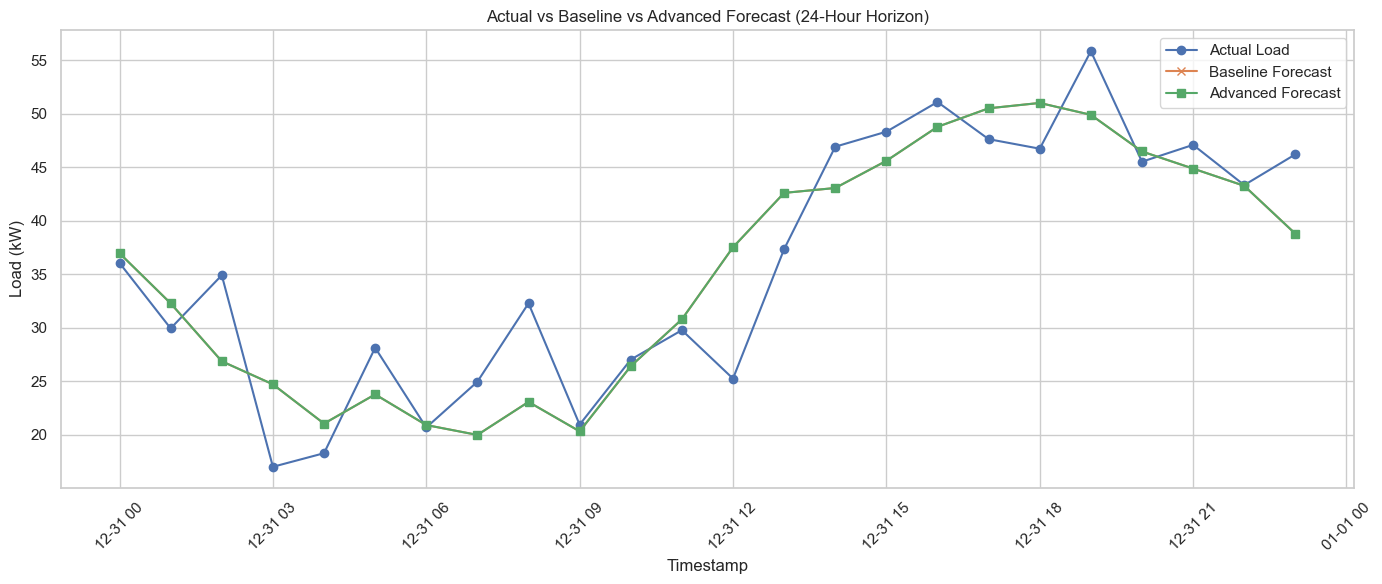

In [77]:
# Plot actual vs predicted
plot_forecast_comparison(
    timestamps=test_df["timestamp"],
    actual=y_test.values,
    baseline=y_pred_rf,
    advanced=y_pred_rf
)


## Evaluation & Visualization: Baseline vs Advanced Forecast


In [78]:
# Compute baseline errors again for comparison

y_true = baseline_df["actual_load_kW"]
y_pred_baseline = baseline_df["predicted_load_kW"]

mae_base = mean_absolute_error(y_true, y_pred_baseline)
rmse_base = mean_squared_error(y_true, y_pred_baseline, squared=False)
mape_base = mean_absolute_percentage_error(y_true, y_pred_baseline) * 100

print("Baseline Forecast Errors:")
print(f"MAE: {mae_base:.2f}")
print(f"RMSE: {rmse_base:.2f}")
print(f"MAPE: {mape_base:.2f}%")


Baseline Forecast Errors:
MAE: 5.46
RMSE: 6.72
MAPE: 17.69%


In [79]:
# Advanced model (Random Forest) metrics — already computed
print("Advanced Model (Random Forest) Forecast Errors:")
print(f"MAE: {mae_rf:.2f}")
print(f"RMSE: {rmse_rf:.2f}")
print(f"MAPE: {mape_rf:.2f}%")


Advanced Model (Random Forest) Forecast Errors:
MAE: 3.88
RMSE: 4.99
MAPE: 12.41%


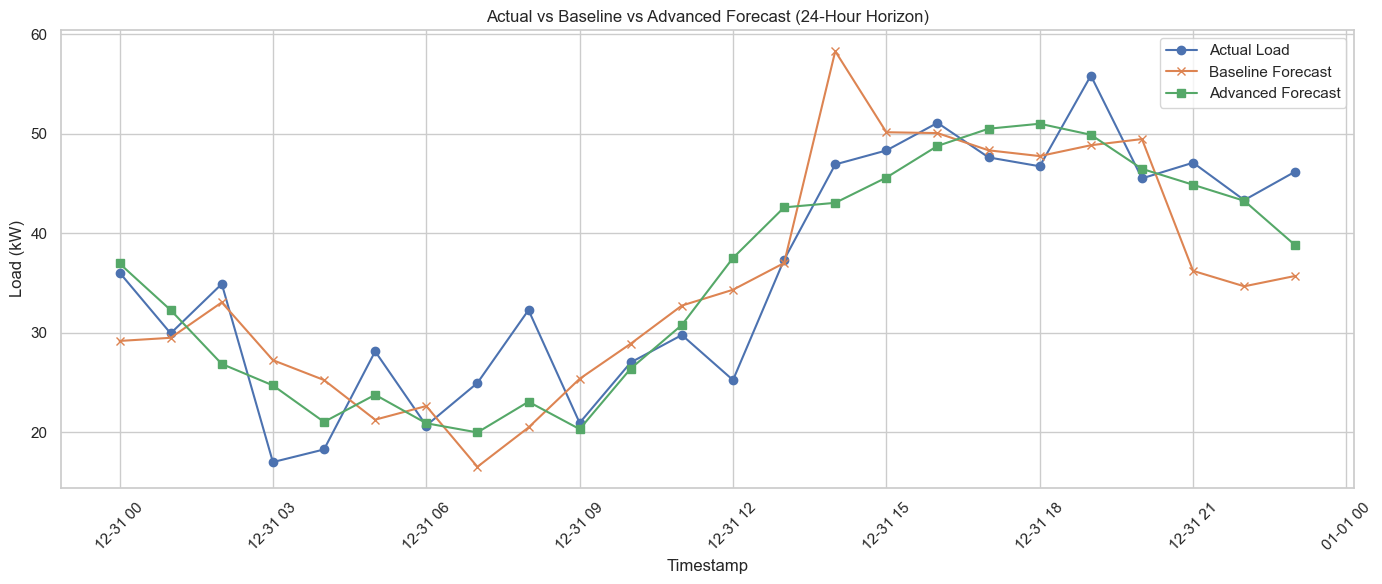

In [80]:
# Plot actual, baseline, and advanced model predictions
plot_forecast_comparison(
    timestamps=baseline_df["timestamp"],
    actual=y_true,
    baseline=y_pred_baseline,
    advanced=y_pred_rf
)


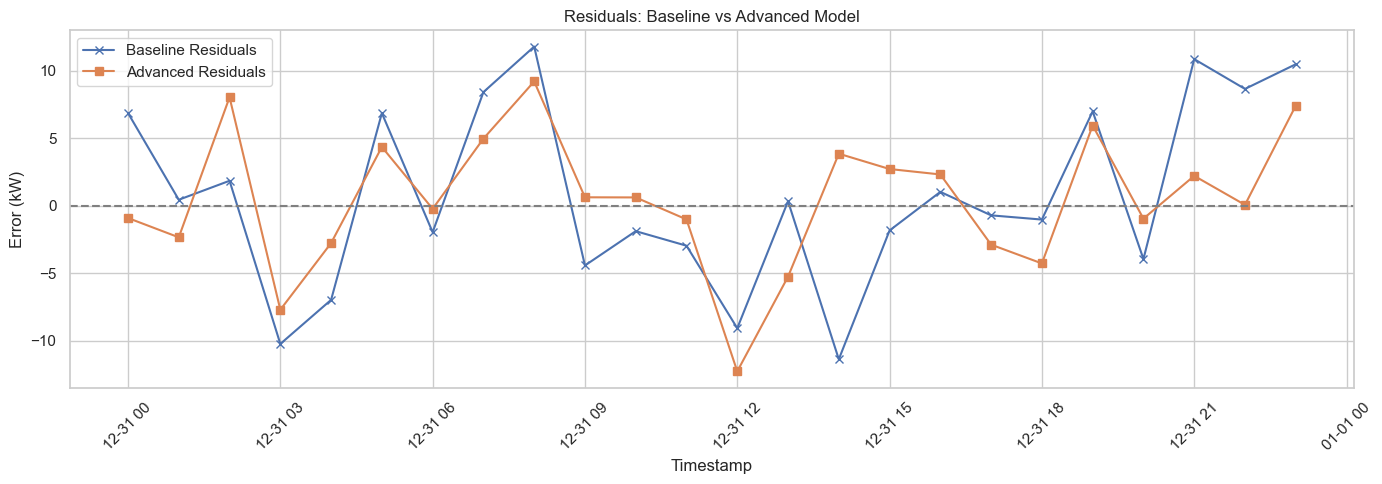

In [81]:
# Residuals: Actual - Predicted
# Compute residuals first
baseline_residuals = y_true - y_pred_baseline
rf_residuals = y_true - y_pred_rf

# Use utility function to plot
plot_residuals(
    timestamps=baseline_df["timestamp"],
    baseline_residuals=baseline_residuals,
    advanced_residuals=rf_residuals
)
